<a href="https://colab.research.google.com/github/Fidelisaboke/robust-nids/blob/feat%2Fbaseline-model/notebooks/04_baseline_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Model Training

## Mount Google Drive

In [234]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Required Libraries

In [235]:
# Data manipulation
import numpy as np
import pandas as pd

# Standard library for mathematical operations
import math

# Random number generation
import random

# For handling JSON files
import json

# Progress
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Train-test split + Tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Feature selection
from sklearn.feature_selection import VarianceThreshold

# Scaling and Encoding
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Imbalance handling
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Scikit-Learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC, OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

# Tensorflow - For Autoencoder (AEs)
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential, regularizers

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    make_scorer,
    roc_curve,
    auc,
    precision_recall_fscore_support
)


# For saving models
import joblib

## Constants and Configuration

In [236]:
# Clean CSV Path
CLEAN_CSV_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/cleaned_data.csv"

# Scaler (Supervised)
SUPERVISED_SCALER_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/supervised_scaler.pkl"

# Scaler (Unsupervised)
UNSUPERVISED_SCALER_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/unsupervised_scaler.pkl"

# Label Encoder
LABEL_ENCODER_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/label_encoder.pkl"

# Binary Classifier Path
BINARY_CLASSIFIER_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/binary_classifier.pkl"

# Multiclass Classifier Path
MULTICLASS_CLASSIFIER_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/multiclass_classifier.pkl"

# Binary Features Path
BINARY_FEATURES_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/binary_features.json"

# Mutliclass Features Path
MULTICLASS_FEATURES_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/multiclass_features.json"

## Load the Dataset

In [237]:
df = pd.read_csv(CLEAN_CSV_PATH)
df.head()

,ACK Flag Count,Active Max,Active Mean,Active Min,Active Std,Average Packet Size,Bwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Header Length,Bwd IAT Max,...,Total Fwd Packet,Total Length of Bwd Packet,Total Length of Fwd Packet,URG Flag Count,Label,Traffic Type,Traffic Subtype,Protocol_0.0,Protocol_6.0,Protocol_17.0
0,3493.0,0.0,0.000000e+00,0.0,0.000000e+00,83.142816,7187.0,72603.0,57384.0,3256370.0,...,1701.0,140566.0,149935.0,0.0,0,Audio,Audio,0.0,1.0,0.0
1,93.0,19996926.0,1.802327e+07,14078617.0,3.416174e+06,31.946237,157.0,182.0,1836.0,5003516.0,...,36.0,1650.0,1280.0,0.0,0,Audio,Audio,0.0,1.0,0.0
2,2.0,0.0,0.000000e+00,0.0,0.000000e+00,124.000000,0.0,0.0,32.0,0.0,...,1.0,0.0,124.0,0.0,0,Audio,Audio,0.0,1.0,0.0
3,8127.0,0.0,0.000000e+00,0.0,0.000000e+00,86.780635,7317.0,100716.0,134508.0,3663475.0,...,3932.0,301478.0,403875.0,0.0,0,Audio,Audio,0.0,1.0,0.0
4,0.0,0.0,0.000000e+00,0.0,0.000000e+00,78.452346,5507.0,76426.0,54360.0,4685411.0,...,25.0,534811.0,225.0,0.0,0,Audio,Audio,0.0,0.0,1.0


### Heavily undersampling the malicious class

In [238]:
benign = df[df['Label'] == 0]
malicious = df[df['Label'] == 1]

# Undersample malicious
ratio = 1
malicious_sampled = malicious.sample(n=len(benign) * 100, random_state=42)

# A little more malicious to keep variety:
# malicious_sampled = malicious.sample(n=len(benign)*3, random_state=42)

# Combine back
balanced_df = pd.concat([benign, malicious_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset size:", balanced_df.shape)
print(balanced_df['Label'].value_counts())


Balanced dataset size: (130189, 82)
Label
1    128900
0      1289
Name: count, dtype: int64


#### Setting the balanced dataframe to the main dataframe

In [239]:
df = balanced_df

## Supervised Learning - Binary Classification

### Separate features from labels

In [240]:
X = df.drop(columns=["Label", "Traffic Type", "Traffic Subtype"])
y = df["Label"] # Target for binary classification

### Train-test split
- Split: 70% training, 15% testing, 15% validation
- Statification is applied to preserve class balance

In [241]:
# Split into train (70%) and val + test (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split the 30% into val (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Train size: (91132, 79)
Validation size: (19528, 79)
Test size: (19529, 79)


### Feature Scaling


In [242]:
# Separate categorical and numerical columns
protocol_cols = ["Protocol_0.0", "Protocol_6.0", "Protocol_17.0"]
categorical_cols = list(X_train.select_dtypes(include=['object']).columns) + protocol_cols
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

# Create scaler instance
scaler = MinMaxScaler()

# Fit scaler only on numerical features of training set
scaler.fit(X_train[numerical_cols])

# Transform train/val/test numerical features
X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols]  = scaler.transform(X_test[numerical_cols])

#### Save the scaler for use later

In [243]:
try:
  joblib.dump(scaler, SUPERVISED_SCALER_PATH)
  print(f"Scaler saved to: {SUPERVISED_SCALER_PATH}")
except Exception as e:
  print(f"Error saving scaler: {e}")

Scaler saved to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/supervised_scaler.pkl


### Feature Selection
- Selecting the best features to use for model training

#### Feature selection function

In [244]:
def fast_feature_selection(X_train, y_train, corr_threshold=0.9, top_n=20):
    """
    Lightweight feature selection:
      1. Remove near-constant variance features
      2. Remove highly correlated features
      3. Rank top N using XGBoost feature importance
    """
    print(f"Initial features: {X_train.shape[1]}")

    # Step 1: Remove near-zero variance features
    vt = VarianceThreshold(threshold=0.0)
    vt.fit(X_train)
    X_var = X_train.loc[:, vt.get_support()]
    print(f"After variance filter: {X_var.shape[1]} features")

    # Step 2: Remove highly correlated features
    corr = X_var.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > corr_threshold)]
    X_uncorr = X_var.drop(columns=to_drop)
    print(f"After correlation filter: {X_uncorr.shape[1]} features")

    # Step 3: XGBoost-based ranking
    model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42,
        verbosity=0
    )
    model.fit(X_uncorr, y_train)

    importances = pd.Series(model.feature_importances_, index=X_uncorr.columns)
    top_features = importances.sort_values(ascending=False).head(top_n).index.tolist()

    print(f"Selected top {top_n} features:")
    for idx, feature in enumerate(top_features, start=1):
        print(f"{idx}. {feature}")

    return top_features, importances


#### Feature importance plotting function

In [245]:
def plot_feature_importance(importance_scores: pd.Series, top_n: int = 20):
    """
    Visualize top N feature importances as a horizontal bar chart.
    """
    top_features = importance_scores.sort_values(ascending=True).tail(top_n)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_features.values, y=top_features.index, orient="h")
    plt.title("Feature importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

#### Selecting features to use

In [246]:
selected_features, feature_importances = fast_feature_selection(
    X_train_scaled,
    y_train,
    corr_threshold=0.9,
    top_n=20
)

X_train_sel = X_train_scaled[selected_features]
X_val_sel   = X_val_scaled[selected_features]
X_test_sel  = X_test_scaled[selected_features]

print("Reduced shapes:")
print(X_train_sel.shape, X_val_sel.shape, X_test_sel.shape)

Initial features: 79
After variance filter: 74 features
After correlation filter: 49 features
Selected top 20 features:
1. Total Fwd Packet
2. Flow Duration
3. Packet Length Min
4. Bwd Bytes/Bulk Avg
5. Average Packet Size
6. Bwd IAT Mean
7. Flow IAT Min
8. SYN Flag Count
9. Fwd Act Data Pkts
10. Protocol_6.0
11. Bwd Packet Length Std
12. Total Length of Bwd Packet
13. Bwd Init Win Bytes
14. Total Bwd packets
15. FWD Init Win Bytes
16. Subflow Fwd Packets
17. Bwd Packet Length Max
18. Fwd Seg Size Min
19. Subflow Fwd Bytes
20. RST Flag Count
Reduced shapes:
(91132, 20) (19528, 20) (19529, 20)


#### Feature Importance Plot

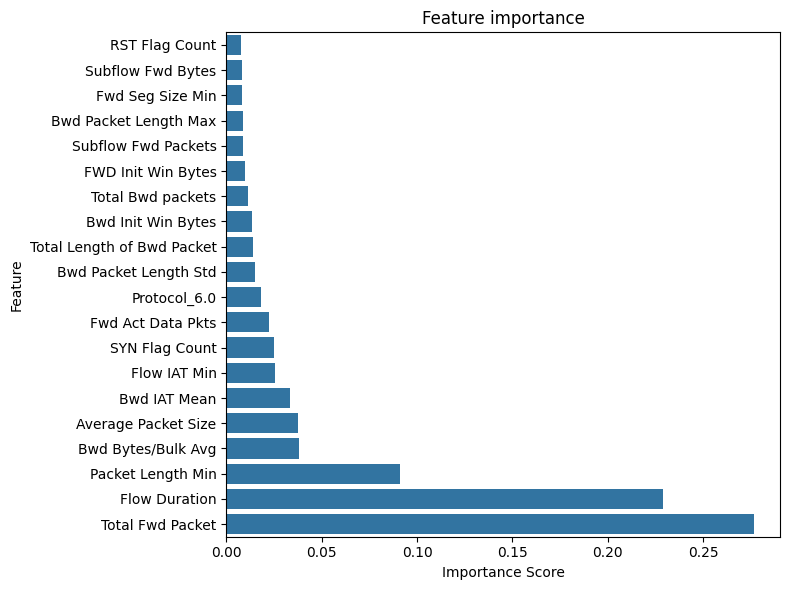

In [247]:
plot_feature_importance(feature_importances)

#### Save selected features to JSON

In [249]:
try:
  with open(BINARY_FEATURES_PATH, "w") as f:
      json.dump(selected_features, f)
  print(f"Saved binary features to: {BINARY_FEATURES_PATH}")
except Exception as e:
  print(f"Error saving binary features: {e}")

Saved binary features to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/binary_features.json


#### Create and fit new scaler after feature selection

In [214]:
# Create and fit new scaler
scaler_sel = MinMaxScaler()
scaler_sel.fit(X_train_sel)

# Transform using the same scaler
X_train_sel= scaler_sel.transform(X_train_sel)
X_val_sel = scaler_sel.transform(X_val_sel)
X_test_sel  = scaler_sel.transform(X_test_sel)

# Save new scaler
try:
  joblib.dump(scaler_sel, SUPERVISED_SCALER_PATH)
  print(f"Scaler saved to: {SUPERVISED_SCALER_PATH}")
except Exception as e:
  print(f"Error saving scaler: {e}")

Scaler saved to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/supervised_scaler.pkl


### Model Training and Validation
- The following classifiers will be trained to establish a fair baseline:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. SVM (RBF kernel) (for non-linear separation)
5. MLP (shallow neutral net)

In [215]:
# Models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=200,
        random_state=42,
        early_stopping=True
    )
}

# Apply SMOTE to training set (optional toggle)
use_smote = False
if use_smote:
  smote = SMOTE(random_state=42)
  X_train_bal, y_train_bal = smote.fit_resample(X_train_sel, y_train)
else:
  X_train_bal, y_train_bal = X_train_sel, y_train
  print("Skipping SMOTE...")

# Results list
results = []

for name, model in tqdm(models.items(), desc="Training Models", unit="model"):
  # Fit on training set
  model.fit(X_train_bal, y_train_bal)

  # Validation performance
  y_val_pred = model.predict(X_val_sel)
  y_val_prob = model.predict_proba(X_val_sel)[:, 1] if hasattr(model, "predict_proba") else None

  print(f"\n\n{name} Validation Results:")
  print(classification_report(y_val, y_val_pred))

  # Compile metrics
  metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_val_pred),
        "Precision": precision_score(y_val, y_val_pred, average="binary", pos_label=1),
        "Recall": recall_score(y_val, y_val_pred, average="binary", pos_label=1),
        "F1": f1_score(y_val, y_val_pred, average="binary", pos_label=1),
        "Confusion Matrix": confusion_matrix(y_val, y_val_pred)
  }

  if y_val_prob is not None:
    roc_auc = roc_auc_score(y_val, y_val_prob)
    print("ROC-AUC (val): ", roc_auc)
    metrics["ROC-AUC"] = roc_auc
  else:
    metrics["ROC-AUC"] = None

  results.append(metrics)

Skipping SMOTE...


Training Models:  20%|██        | 1/5 [00:00<00:01,  3.43model/s]



Logistic Regression Validation Results:
              precision    recall  f1-score   support

           0       0.92      0.32      0.47       193
           1       0.99      1.00      1.00     19335

    accuracy                           0.99     19528
   macro avg       0.96      0.66      0.73     19528
weighted avg       0.99      0.99      0.99     19528

ROC-AUC (val):  0.9316717381429955


Training Models:  40%|████      | 2/5 [00:11<00:19,  6.51s/model]



Random Forest Validation Results:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       193
           1       1.00      1.00      1.00     19335

    accuracy                           1.00     19528
   macro avg       0.98      0.96      0.97     19528
weighted avg       1.00      1.00      1.00     19528

ROC-AUC (val):  0.9815065969388918


XGBoost Validation Results:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       193
           1       1.00      1.00      1.00     19335

    accuracy                           1.00     19528
   macro avg       0.99      0.97      0.98     19528
weighted avg       1.00      1.00      1.00     19528



Training Models:  60%|██████    | 3/5 [00:15<00:10,  5.47s/model]

ROC-AUC (val):  0.9998209909544157


Training Models:  80%|████████  | 4/5 [01:36<00:35, 35.14s/model]



SVM Validation Results:
              precision    recall  f1-score   support

           0       0.94      0.54      0.68       193
           1       1.00      1.00      1.00     19335

    accuracy                           1.00     19528
   macro avg       0.97      0.77      0.84     19528
weighted avg       0.99      1.00      0.99     19528

ROC-AUC (val):  0.9788960930203892


Training Models: 100%|██████████| 5/5 [01:50<00:00, 22.07s/model]



MLP Validation Results:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       193
           1       1.00      1.00      1.00     19335

    accuracy                           1.00     19528
   macro avg       0.97      0.90      0.94     19528
weighted avg       1.00      1.00      1.00     19528

ROC-AUC (val):  0.996350546875314


### Results Dataframe

In [216]:
# Convert results into a pandas dataframe
results_df = pd.DataFrame(results)

# Remove confusion matrix for results display
print(results_df.drop("Confusion Matrix", axis=1))

                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  0.992984   0.993218  0.999741  0.996469  0.931672
1        Random Forest  0.998822   0.999224  0.999586  0.999405  0.981507
2              XGBoost  0.999283   0.999380  0.999897  0.999638  0.999821
3                  SVM  0.995084   0.995416  0.999638  0.997523  0.978896
4                  MLP  0.997696   0.998089  0.999586  0.998837  0.996351


### Save best model

In [166]:
try:
  joblib.dump(models["XGBoost"], BINARY_CLASSIFIER_PATH)
  print(f"Binary classifier saved to: {BINARY_CLASSIFIER_PATH}")
except Exception as e:
  print(f"Error saving binary classifier: {e}")

Binary classifier saved to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/binary_classifier.pkl


### Visualization of Metrics

#### Function to plot model comparison

In [167]:
def plot_model_comparison(results_df: pd.DataFrame):
  """
  Generates and displays a bar plot comparing classifiers' performance
  across various smetrics.
  """
  df_melt = results_df.melt(
      id_vars=["Model"],
      value_vars=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
      var_name="Metric", value_name="Score"
  )

  plt.figure(figsize=(10,6))
  sns.barplot(data=df_melt, x="Metric", y="Score", hue="Model", palette="Set2")
  plt.ylim(0, 1)
  plt.title("Model Validation Performance", fontsize=14)
  plt.ylabel("Score")
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()

#### Function to plot metric trends

In [ ]:
def plot_metric_trends(results_df: pd.DataFrame):
  """
  Generates and displays a line plot the trend of metrics across models.
  """
  df_melt = results_df.melt(
      id_vars=["Model"],
      value_vars=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
      var_name="Metric", value_name="Score"
  )

  plt.figure(figsize=(10,6))
  sns.lineplot(data=df_melt, x="Metric", y="Score", hue="Model", marker="o")
  plt.ylim(0, 1)
  plt.title("Model Metrics Trend", fontsize=14)
  plt.ylabel("Score")
  plt.show()


#### Function for generating heatmap for quick overview

In [168]:
def plot_metric_heatmap(results_df: pd.DataFrame):
  """
  Generates and displays a heatmap of validation metrics.
  """
  plt.figure(figsize=(8,5))
  sns.heatmap(results_df.set_index("Model"), annot=True, cmap="YlGnBu", fmt=".2f")
  plt.title("Validation Metrics Heatmap", fontsize=14)
  plt.show()


#### Function for generating confusion matrix

In [169]:
def plot_confusion_matrix(results_df: pd.DataFrame):
    """
    Generates and displays confusion matrices for each model.
    """
    n_models = len(results_df)
    n_cols = 2
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
    axes = axes.flatten()  # Flatten to 1D for easy indexing

    for ax, (_, row) in zip(axes, results_df.iterrows()):
        cm = row["Confusion Matrix"]

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False,
                    xticklabels=["Benign", "Malicious"],
                    yticklabels=["Benign", "Malicious"])

        ax.set_title(f"{row['Model']}\nConfusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    # Hide any unused subplots
    for ax in axes[len(results_df):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


### Binary Classification Metrics

#### Metrics Comparison

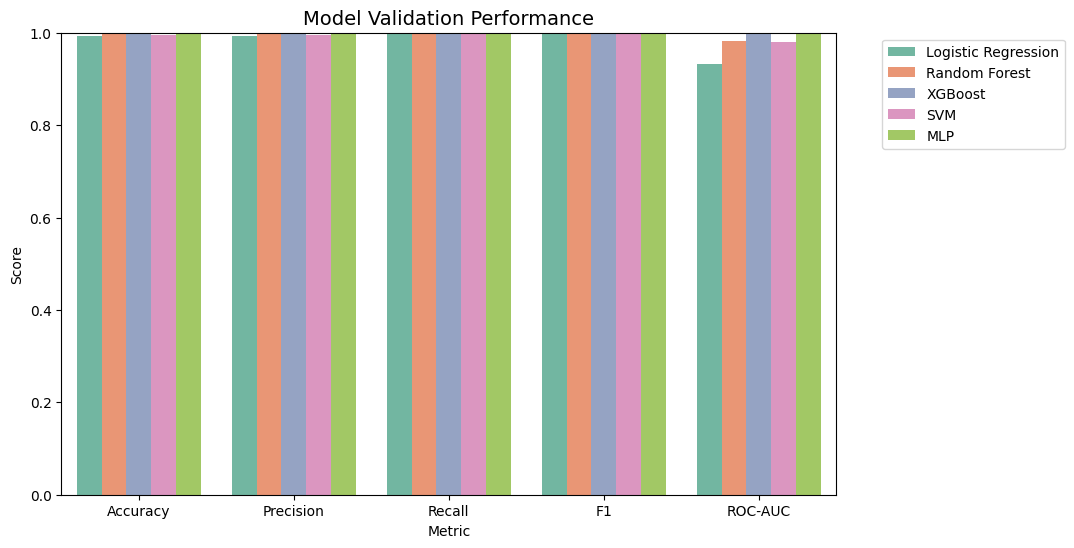

In [170]:
plot_model_comparison(results_df)


### Metric Trends

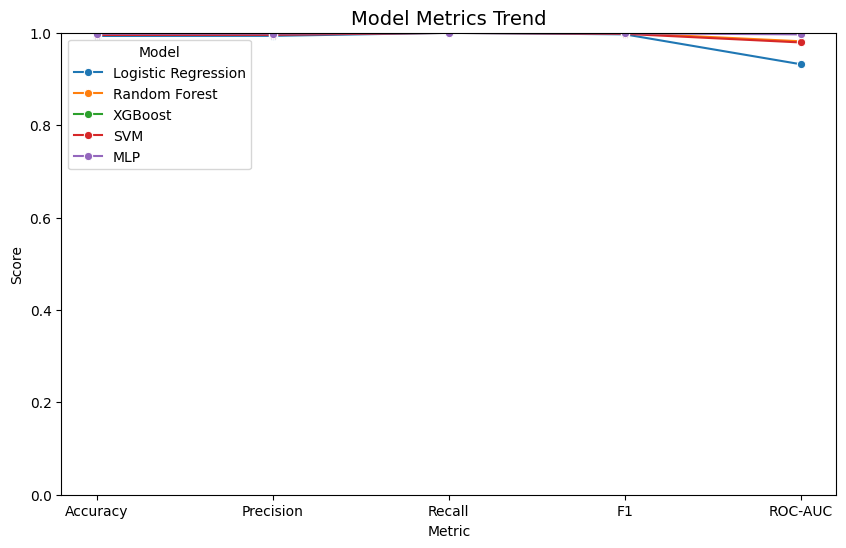

In [171]:
plot_metric_trends(results_df)

### Metric Heatmap

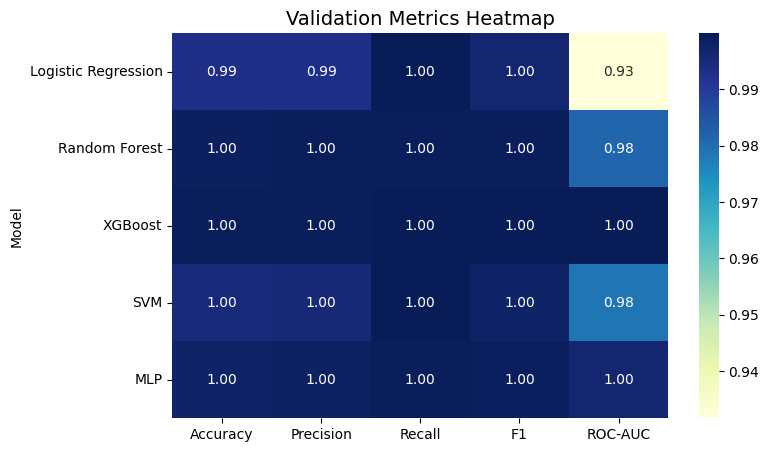

In [172]:
plot_metric_heatmap(results_df.drop("Confusion Matrix", axis=1))

### Confusion matrix

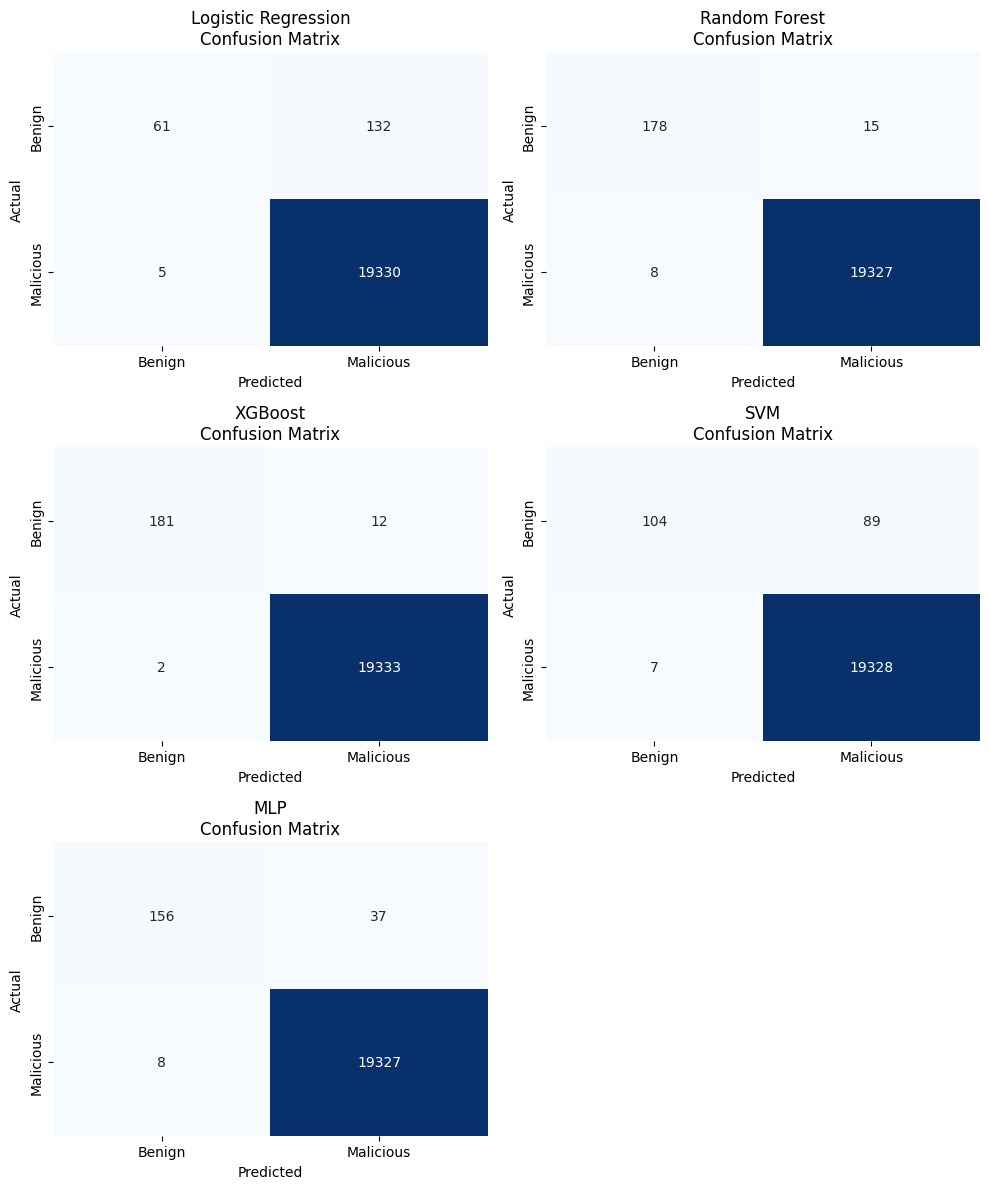

In [173]:
plot_confusion_matrix(results_df)

## Supervised Learning - Multiclass Classification

### Separate features from label

In [257]:
X = df.drop(columns=["Label", "Traffic Type", "Traffic Subtype"])
y = df["Traffic Type"] # Target for multiclass classification

### Train-test split

In [258]:
# Split into train (70%) and val + test (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split the 30% into val (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Train size: (91132, 79)
Validation size: (19528, 79)
Test size: (19529, 79)


### Feature Scaling

In [259]:
# Separate categorical and numerical columns
protocol_cols = ["Protocol_0.0", "Protocol_6.0", "Protocol_17.0"]
categorical_cols = list(X_train.select_dtypes(include=['object']).columns) + protocol_cols
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

# Create scaler instance
scaler = MinMaxScaler()

# Fit scaler only on numerical features of training set
scaler.fit(X_train[numerical_cols])

# Transform train/val/test numerical features
X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_val_scaled[numerical_cols]   = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols]  = scaler.transform(X_test[numerical_cols])

# Save the scaler
try:
  joblib.dump(scaler, SUPERVISED_SCALER_PATH)
  print(f"Scaler saved to: {SUPERVISED_SCALER_PATH}")
except Exception as e:
  print(f"Error saving scaler: {e}")

Scaler saved to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/supervised_scaler.pkl


### Label Encoding
- Applied to Traffic Subtype

In [260]:
encoder = LabelEncoder()
y_train_multi = encoder.fit_transform(y_train)  # 8 classes
y_val_multi = encoder.transform(y_val)
y_test_multi = encoder.transform(y_test)

print("Classes:", encoder.classes_)

Classes: ['Audio' 'Background' 'Bruteforce' 'DoS' 'Information Gathering' 'Mirai'
 'Text' 'Video']


### Save the encoder for use later

In [261]:
# Save the encoder
try:
  joblib.dump(encoder, LABEL_ENCODER_PATH)
  print(f"Label encoder saved to: {LABEL_ENCODER_PATH}")
except Exception as e:
  print(f"Error saving label encoder: {e}")

Label encoder saved to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/label_encoder.pkl


### Feature Selection

#### Feature selection function for multiclass

In [262]:
def fast_feature_selection_multi(X_train, y_train, corr_threshold=0.9, top_n=20):
    """
    Lightweight feature selection for multiclass classification:
      1. Remove near-constant variance features
      2. Remove highly correlated features
      3. Rank top N using XGBoost feature importance (multi-class objective)
    """
    print(f"Initial features: {X_train.shape[1]}")

    # Step 1: Remove near-zero variance features
    vt = VarianceThreshold(threshold=0.0)
    vt.fit(X_train)
    X_var = X_train.loc[:, vt.get_support()]
    print(f"After variance filter: {X_var.shape[1]} features")

    # Step 2: Remove highly correlated features
    corr = X_var.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > corr_threshold)]
    X_uncorr = X_var.drop(columns=to_drop)
    print(f"After correlation filter: {X_uncorr.shape[1]} features")

    # Step 3: XGBoost-based ranking
    num_classes = len(np.unique(y_train))
    model = XGBClassifier(
        objective="multi:softprob",
        num_class=num_classes,
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42,
        verbosity=0
    )
    model.fit(X_uncorr, y_train)

    importances = pd.Series(model.feature_importances_, index=X_uncorr.columns)
    top_features = importances.sort_values(ascending=False).head(top_n).index.tolist()

    print(f"Selected top {top_n} features:")
    for idx, feature in enumerate(top_features, start=1):
        print(f"{idx}. {feature}")

    return top_features, importances

#### Selecting features

In [263]:
selected_features, feature_importances = fast_feature_selection_multi(
    X_train_scaled,
    y_train_multi,
    corr_threshold=0.9,
    top_n=20
)

X_train_sel = X_train_scaled[selected_features]
X_val_sel   = X_val_scaled[selected_features]
X_test_sel  = X_test_scaled[selected_features]

print("Reduced shapes:")
print(X_train_sel.shape, X_val_sel.shape, X_test_sel.shape)

Initial features: 79
After variance filter: 74 features
After correlation filter: 49 features
Selected top 20 features:
1. Average Packet Size
2. Total Length of Bwd Packet
3. Packet Length Min
4. Flow Bytes/s
5. FWD Init Win Bytes
6. Bwd Packet Length Mean
7. Protocol_6.0
8. Total Bwd packets
9. Bwd Packet Length Min
10. Bwd Bytes/Bulk Avg
11. Fwd Seg Size Min
12. Subflow Fwd Bytes
13. Bwd Bulk Rate Avg
14. SYN Flag Count
15. Bwd Packet Length Max
16. Flow IAT Mean
17. Flow IAT Min
18. FIN Flag Count
19. Bwd IAT Total
20. Fwd Act Data Pkts
Reduced shapes:
(91132, 20) (19528, 20) (19529, 20)


#### Feature importance for multiclass classification

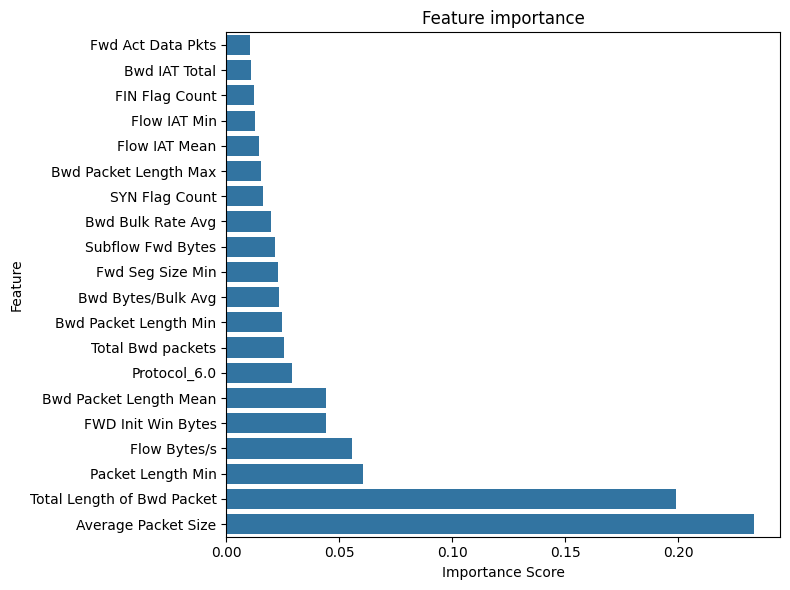

In [264]:
plot_feature_importance(feature_importances)

#### Save best features to JSON

In [265]:
try:
  with open(MULTICLASS_FEATURES_PATH, "w") as f:
      json.dump(selected_features, f)
  print(f"Saved multiclass features to: {MULTICLASS_FEATURES_PATH}")
except Exception as e:
  print(f"Error saving multiclass features: {e}")

Saved multiclass features to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/multiclass_features.json


#### Create new scaler from selected features

In [266]:
# Create and fit new scaler
scaler_sel = MinMaxScaler()
scaler_sel.fit(X_train_sel)

# Transform using the same scaler
X_train_sel= scaler_sel.transform(X_train_sel)
X_val_sel = scaler_sel.transform(X_val_sel)
X_test_sel  = scaler_sel.transform(X_test_sel)

# Save new scaler
try:
  joblib.dump(scaler_sel, SUPERVISED_SCALER_PATH)
  print(f"Scaler saved to: {SUPERVISED_SCALER_PATH}")
except Exception as e:
  print(f"Error saving scaler: {e}")

Scaler saved to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/supervised_scaler.pkl


### Model Training and Validation

In [226]:
# Models to train
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        solver="lbfgs",
        n_jobs=-1,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
    ),
    "SVM": LinearSVC(dual=False, max_iter=1000, random_state=42),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=100,
        early_stopping=True,
        random_state=42
    )
}

# Apply SMOTE to training set (optional toggle)
use_smote = True
if use_smote:
    smote = SMOTE(sampling_strategy="not majority", random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train_sel, y_train_multi)
else:
    X_train_bal, y_train_bal = X_train_sel, y_train_multi
    print("Skipping SMOTE...")

# Results list
results = []

for name, model in tqdm(models.items(), desc="Training Models", unit="model"):
    # Fit on training set
    model.fit(X_train_bal, y_train_bal)

    # Validation performance
    y_val_pred = model.predict(X_val_sel)
    if hasattr(model, "predict_proba"):
      y_val_prob = model.predict_proba(X_val_sel)
    else:
      y_val_prob = None

    print(f"\n\n{name} Validation Results:")
    print(classification_report(y_val_multi, y_val_pred, digits=4))

    # Compile metrics
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_val_multi, y_val_pred),
        "Precision (macro)": precision_score(y_val_multi, y_val_pred, average="macro"),
        "Recall (macro)": recall_score(y_val_multi, y_val_pred, average="macro"),
        "F1 (macro)": f1_score(y_val_multi, y_val_pred, average="macro"),
        "Confusion Matrix": confusion_matrix(y_val_multi, y_val_pred)
    }

    # ROC-AUC (macro average, OVR strategy)
    if y_val_prob is not None:
        try:
            metrics["ROC-AUC"] = roc_auc_score(
                y_val_multi,
                y_val_prob,
                multi_class="ovr",
                average="macro"
            )
            print("ROC-AUC (val):", metrics["ROC-AUC"])
        except Exception as e:
            metrics["ROC-AUC"] = None
            print(f"ROC-AUC failed: {e}")
    else:
        metrics["ROC-AUC"] = None

    results.append(metrics)

Training Models:  20%|██        | 1/5 [01:40<06:40, 100.20s/model]



Logistic Regression Validation Results:
              precision    recall  f1-score   support

           0     0.2745    0.4828    0.3500        29
           1     0.1250    0.8000    0.2162         5
           2     0.4703    0.9086    0.6198       689
           3     0.9970    0.8913    0.9412     15653
           4     0.8583    0.8802    0.8691      1920
           5     0.4030    0.5812    0.4759      1072
           6     0.4894    0.7188    0.5823        32
           7     0.1362    0.5938    0.2216       128

    accuracy                         0.8710     19528
   macro avg     0.4692    0.7321    0.5345     19528
weighted avg     0.9244    0.8710    0.8909     19528

ROC-AUC (val): 0.955248783215265


Training Models:  40%|████      | 2/5 [03:45<05:45, 115.04s/model]



Random Forest Validation Results:
              precision    recall  f1-score   support

           0     0.8571    0.8276    0.8421        29
           1     1.0000    0.8000    0.8889         5
           2     0.9854    0.9826    0.9840       689
           3     0.9991    0.9981    0.9986     15653
           4     1.0000    0.9948    0.9974      1920
           5     0.9813    0.9804    0.9809      1072
           6     0.5510    0.8438    0.6667        32
           7     0.8723    0.9609    0.9145       128

    accuracy                         0.9955     19528
   macro avg     0.9058    0.9235    0.9091     19528
weighted avg     0.9960    0.9955    0.9957     19528

ROC-AUC (val): 0.989063833277546


Training Models:  60%|██████    | 3/5 [04:43<02:57, 88.96s/model] 



XGBoost Validation Results:
              precision    recall  f1-score   support

           0     0.9259    0.8621    0.8929        29
           1     0.8000    0.8000    0.8000         5
           2     0.9783    0.9826    0.9804       689
           3     0.9995    0.9980    0.9987     15653
           4     0.9990    0.9964    0.9977      1920
           5     0.9813    0.9813    0.9813      1072
           6     0.5510    0.8438    0.6667        32
           7     0.8705    0.9453    0.9064       128

    accuracy                         0.9955     19528
   macro avg     0.8882    0.9262    0.9030     19528
weighted avg     0.9960    0.9955    0.9957     19528

ROC-AUC (val): 0.9997709378514086


Training Models:  80%|████████  | 4/5 [05:55<01:22, 82.20s/model]



SVM Validation Results:
              precision    recall  f1-score   support

           0     0.8824    0.5172    0.6522        29
           1     0.1250    0.8000    0.2162         5
           2     0.4330    0.9144    0.5877       689
           3     0.9951    0.8880    0.9385     15653
           4     0.8670    0.8760    0.8715      1920
           5     0.3868    0.5756    0.4627      1072
           6     0.4340    0.7188    0.5412        32
           7     0.1645    0.6016    0.2584       128

    accuracy                         0.8679     19528
   macro avg     0.5360    0.7364    0.5660     19528
weighted avg     0.9226    0.8679    0.8877     19528



Training Models: 100%|██████████| 5/5 [18:20<00:00, 220.13s/model]



MLP Validation Results:
              precision    recall  f1-score   support

           0     0.9167    0.7586    0.8302        29
           1     0.2353    0.8000    0.3636         5
           2     0.8691    0.9826    0.9223       689
           3     0.9994    0.9907    0.9951     15653
           4     0.9796    0.9990    0.9892      1920
           5     0.9616    0.9347    0.9480      1072
           6     0.3544    0.8750    0.5045        32
           7     0.9554    0.8359    0.8917       128

    accuracy                         0.9866     19528
   macro avg     0.7839    0.8971    0.8056     19528
weighted avg     0.9891    0.9866    0.9874     19528

ROC-AUC (val): 0.9937754554859044


### Save best model

In [227]:
try:
  joblib.dump(models["XGBoost"], MULTICLASS_CLASSIFIER_PATH)
  print(f"Multiclass classifier saved to: {MULTICLASS_CLASSIFIER_PATH}")
except Exception as e:
  print(f"Error saving multiclass classifier: {e}")

Multiclass classifier saved to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/multiclass_classifier.pkl


### Confusion Matrix

#### Function to plot confusion matrix for multiclass

In [228]:

def plot_confusion_matrix_multiclass(results_df: pd.DataFrame, class_names: list):
    """
    Generates and displays a confusion matrix for each model (multiclass version).
    """
    n_models = len(results_df)
    n_cols = 2  # two plots per row
    n_rows = int(np.ceil(n_models / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

    # Flatten axes for easy iteration
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, results_df.iterrows()):
        cm = row["Confusion Matrix"]

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False,
                    xticklabels=class_names,
                    yticklabels=class_names)

        ax.set_title(f"{row['Model']}\nConfusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    # Hide unused subplots (if any)
    for i in range(len(results_df), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


#### Confusion Matrix Display

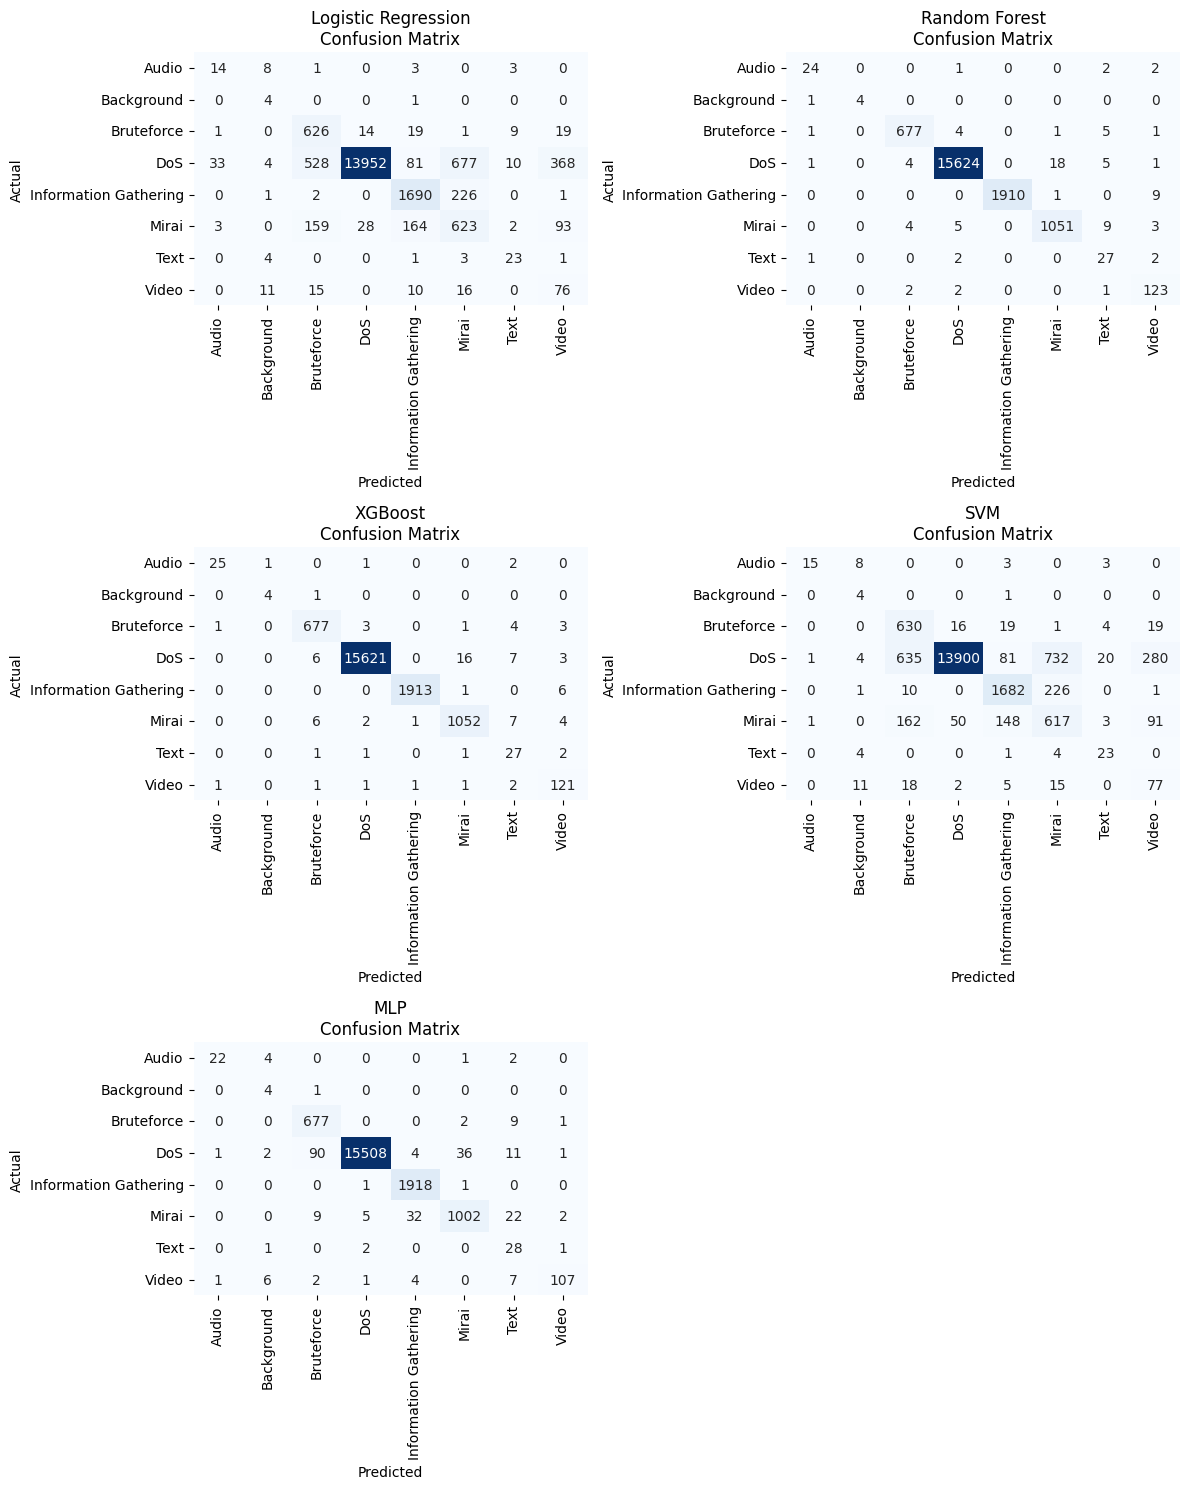

In [229]:
results_df = pd.DataFrame(results)
class_names = sorted(encoder.classes_)
plot_confusion_matrix_multiclass(results_df, class_names)

## Unsupervised Learning
- The idea for unsupervised learning:
1. Train models only on benign traffic
2. During inference, detect whether new samples deviate significantly to determine anomalies

### Preprocessing
- Split data into benign and malicious

In [230]:
# Columns to drop for unsupervised learning
cols_to_drop = ["Label", "Traffic Type", "Traffic Subtype"]

# Separate benign from malicious
df_benign = df[df['Label'] == 0].copy()
df_mal = df[df['Label'] == 1].copy()

X_benign = df_benign.drop(columns=cols_to_drop)
X_mal = df_mal.drop(columns=cols_to_drop)

print("Benign data shape:", X_benign.shape)
print("Malicious data shape:", X_mal.shape)

Benign data shape: (1289, 79)
Malicious data shape: (128900, 79)


### Train-test split

In [231]:
# Split into train and val+test
X_benign_train, X_benign_temp = train_test_split(
    X_benign, test_size=0.30, random_state=42
)

# Split into val+test
X_benign_val, X_benign_test = train_test_split(
    X_benign_temp, test_size=0.50, random_state=42
)

print("Benign Train size:", X_benign_train.shape)
print("Benign Validation size:", X_benign_val.shape)
print("Benign Test size:", X_benign_test.shape)

Benign Train size: (902, 79)
Benign Validation size: (193, 79)
Benign Test size: (194, 79)


### Feature Scaling

In [ ]:
# Separate categorical and numerical columns
protocol_cols = ["Protocol_0.0", "Protocol_6.0", "Protocol_17.0"]
categorical_cols = list(X_benign_train.select_dtypes(include=['object']).columns) + protocol_cols
numerical_cols = [col for col in X_benign_train.columns if col not in categorical_cols]

# Create scaler instance
scaler = MinMaxScaler()

# Fit scaler only on numerical features of benign training set
scaler.fit(X_benign_train[numerical_cols])

# Transform train/val/test numerical features
X_benign_train_scaled = X_benign_train.copy()
X_benign_val_scaled   = X_benign_val.copy()
X_benign_test_scaled  = X_benign_test.copy()
X_mal_scaled = X_mal.copy()

X_benign_train_scaled[numerical_cols] = scaler.transform(X_benign_train[numerical_cols])
X_benign_val_scaled[numerical_cols]   = scaler.transform(X_benign_val[numerical_cols])
X_benign_test_scaled[numerical_cols]  = scaler.transform(X_benign_test[numerical_cols])

# Transform malicious data
X_mal_scaled[numerical_cols] = scaler.transform(X_mal[numerical_cols])

### Create mixed test sets for evaluation

In [ ]:
# Create mixed test set for evaluation
X_test_scaled = np.concatenate((X_benign_test_scaled, X_mal_scaled), axis=0)
y_test_scaled = np.concatenate(
    (np.zeros(X_benign_test_scaled.shape[0]), np.ones(X_mal_scaled.shape[0])),
    axis=0
)

# Small validation mixed sets (benign+malicious)
X_val_scaled = np.concatenate((X_benign_val_scaled, X_mal_scaled), axis=0)
y_val_scaled = np.concatenate(
    (np.zeros(X_benign_val_scaled.shape[0]), np.ones(X_mal_scaled.shape[0])),
    axis=0
)

print("Test set size:", X_test_scaled.shape)
print("Validation set size:", X_val_scaled.shape)

Test set size: (129094, 79)
Validation set size: (129093, 79)


### Model Training and Validation
- Candidate Models
1. One-Class SVM: Learns boundary around benign traffic
2. Isolation Forest: Isolates anomalies by random splits
3. Local Outlier Factor (LOF): Detects density anomalies
4. Elliptic Envelope: Fits an ellipse around the data points
5. Autoencoder (AE): Will be trained to reconstruct benign traffic.

In [ ]:
anomaly_models = {
    "Isolation Forest": IsolationForest(contamination=0.05, random_state=42),
    "One-Class SVM": OneClassSVM(kernel="rbf", gamma="scale", nu=0.05),
    "Elliptic Envelope": EllipticEnvelope(contamination=0.05, random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(
        novelty=True,
        n_neighbors=20,
        contamination=0.05,
    ),
}

# Dict for saving trained models
trained_models = {}

# List for storing anomaly results
anomaly_results = []

for name, model in anomaly_models.items():
  # Fit the model on benign traffic (scaled)
  model.fit(X_benign_train_scaled.values)

  # Save the trained model
  trained_models[name] = model

  # Predict on validation set
  y_val_pred = model.predict(X_val_scaled)
  y_test_pred = model.predict(X_test_scaled)

  # Map outputs
  y_val_pred = np.where(y_val_pred == 1, 0, 1)
  y_test_pred = np.where(y_test_pred == 1, 0, 1)

  # Evaluate
  print(f"\n\n{name} Validation Results:")
  print(classification_report(y_val_scaled, y_val_pred))

  print(f"\n\n{name} Test Results:")
  print(classification_report(y_test_scaled, y_test_pred))

  # Compile metrics
  anomaly_metrics = {
      "Model": name,
      "Accuracy": accuracy_score(y_val_scaled, y_val_pred),
      "Precision": precision_score(y_val_scaled, y_val_pred, average="binary"),
      "Recall": recall_score(y_val_scaled, y_val_pred, average="binary"),
      "F1": f1_score(y_val_scaled, y_val_pred, average="binary"),
      "Confusion Matrix": confusion_matrix(y_val_scaled, y_val_pred),
      "ROC-AUC": roc_auc_score(y_val_scaled, y_val_pred)
  }

  anomaly_results.append(anomaly_metrics)



Isolation Forest Validation Results:
              precision    recall  f1-score   support

         0.0       0.00      0.94      0.00       193
         1.0       1.00      0.15      0.26    128900

    accuracy                           0.15    129093
   macro avg       0.50      0.54      0.13    129093
weighted avg       1.00      0.15      0.25    129093



Isolation Forest Test Results:
              precision    recall  f1-score   support

         0.0       0.00      0.91      0.00       194
         1.0       1.00      0.15      0.26    128900

    accuracy                           0.15    129094
   macro avg       0.50      0.53      0.13    129094
weighted avg       1.00      0.15      0.25    129094



One-Class SVM Validation Results:
              precision    recall  f1-score   support

         0.0       0.00      0.96      0.01       193
         1.0       1.00      0.47      0.64    128900

    accuracy                           0.47    129093
   macro avg       0

/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(




Elliptic Envelope Validation Results:
              precision    recall  f1-score   support

         0.0       0.00      0.93      0.00       193
         1.0       1.00      0.05      0.09    128900

    accuracy                           0.05    129093
   macro avg       0.50      0.49      0.05    129093
weighted avg       1.00      0.05      0.09    129093



Elliptic Envelope Test Results:
              precision    recall  f1-score   support

         0.0       0.00      0.92      0.00       194
         1.0       1.00      0.05      0.09    128900

    accuracy                           0.05    129094
   macro avg       0.50      0.48      0.05    129094
weighted avg       1.00      0.05      0.09    129094



Local Outlier Factor Validation Results:
              precision    recall  f1-score   support

         0.0       0.00      0.97      0.01       193
         1.0       1.00      0.60      0.75    128900

    accuracy                           0.60    129093
   macro av

### Unsupervised Learning Results

In [ ]:
results_df = pd.DataFrame(anomaly_results)
print(results_df)

                  Model  Accuracy  Precision    Recall        F1  \
0      Isolation Forest  0.147336   0.999363  0.146152  0.255010   
1         One-Class SVM  0.471335   0.999885  0.470597  0.639985   
2     Elliptic Envelope  0.050909   0.997815  0.049597  0.094496   
3  Local Outlier Factor  0.602945   0.999923  0.602397  0.751848   

               Confusion Matrix   ROC-AUC  
0  [[181, 12], [110061, 18839]]  0.541988  
1    [[186, 7], [68240, 60660]]  0.717164  
2   [[179, 14], [122507, 6393]]  0.488529  
3    [[187, 6], [51251, 77649]]  0.785655  


### ROC Curves

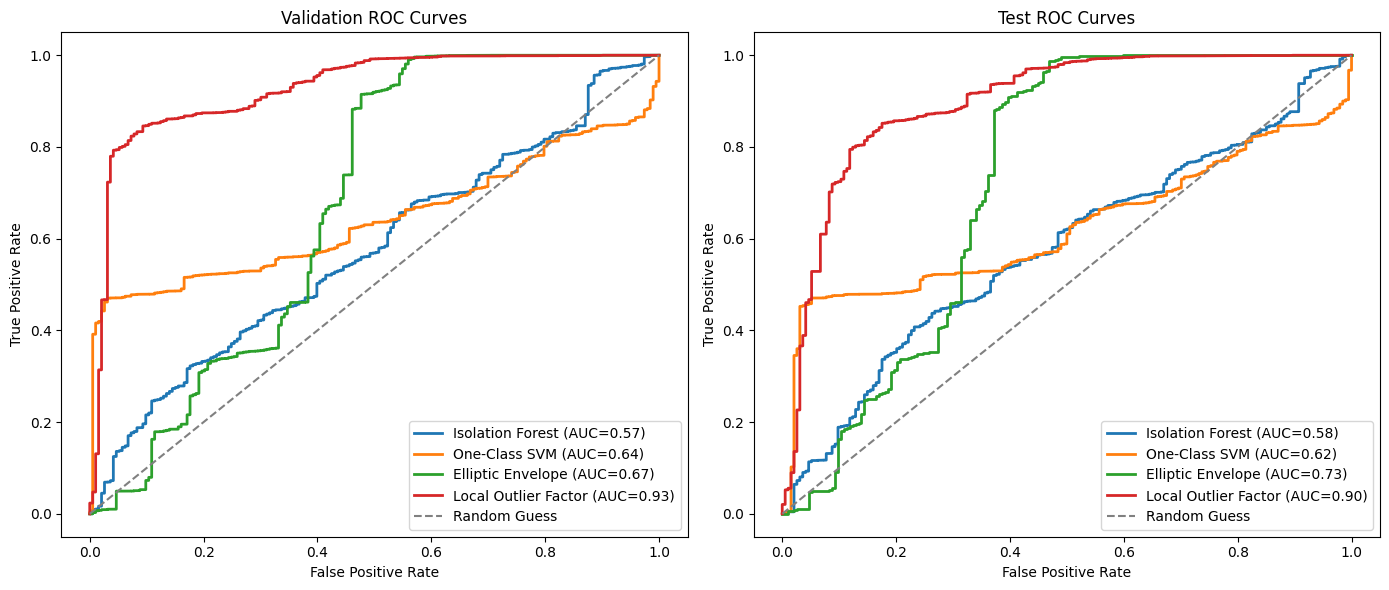

In [ ]:
# two plots: Val (left), Test (right)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Validation ROC Curves ---
for name, model in anomaly_models.items():
    # Try decision_function, else fall back
    try:
        y_val_scores = model.decision_function(X_val_scaled)
    except AttributeError:
        y_val_scores = model.score_samples(X_val_scaled)

    fpr, tpr, _ = roc_curve(y_val_scaled, y_val_scores)
    roc_auc = auc(fpr, tpr)

    # Flip if AUC worse than random
    if roc_auc < 0.5:
        y_val_scores = -y_val_scores
        fpr, tpr, _ = roc_curve(y_val_scaled, y_val_scores)
        roc_auc = auc(fpr, tpr)

    axes[0].plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.2f})")

axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
axes[0].set_title("Validation ROC Curves")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(loc="lower right")

# --- Test ROC Curves ---
for name, model in anomaly_models.items():
    try:
        y_test_scores = model.decision_function(X_test_scaled)
    except AttributeError:
        y_test_scores = model.score_samples(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test_scaled, y_test_scores)
    roc_auc = auc(fpr, tpr)

    if roc_auc < 0.5:
        y_test_scores = -y_test_scores
        fpr, tpr, _ = roc_curve(y_test_scaled, y_test_scores)
        roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.2f})")

axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
axes[1].set_title("Test ROC Curves")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


## Autoencoder

### Autoencoder Architecture

In [ ]:
# Get the input dimension
input_dim = X_benign_train_scaled.shape[1]

autoencoder = Sequential([
    # Input layer
    layers.Input(shape=(input_dim,)),

    # Encoder
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.1),

    layers.Dense(32, activation="relu"),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Bottleneck (Latent representation)
    layers.Dense(16, activation="relu", activity_regularizer=regularizers.l1(1e-5)),

    # Decoder
    layers.Dense(32, activation="relu"),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Dense(64, activation="relu"),
    layers.LeakyReLU(),
    layers.Dense(input_dim, activation="sigmoid")
])

# Compile Autoencoder
autoencoder.compile(optimizer="adam", loss="mae")
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 79)             │         5,135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,031 (62.62 KB)

 Trainable params: 15,775 (61.62 KB)

 Non-trainable params: 256 (1.00 KB)

### Autoencoder Training

In [ ]:
# Fit on scaled benign data
history = autoencoder.fit(
    X_benign_train_scaled,
    X_benign_train_scaled,
    epochs=80,
    batch_size=128,
    validation_data=(X_benign_val_scaled, X_benign_val_scaled),
    shuffle=True,
)

Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.4703 - val_loss: 0.4550
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4397 - val_loss: 0.4510
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4046 - val_loss: 0.4453
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3618 - val_loss: 0.4377
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3145 - val_loss: 0.4273
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2660 - val_loss: 0.4134
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2226 - val_loss: 0.3949
Epoch 8/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1854 - val_loss: 0.3732
Epoch 9/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1533 - val_loss: 0.3496
Epoch 10/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1293 - val_loss: 0.3257
Epoch 11/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1146 - val_loss: 0.3059
Epoch 12/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1033 - val_loss: 0.2899
E

### Plot autoencoder training history

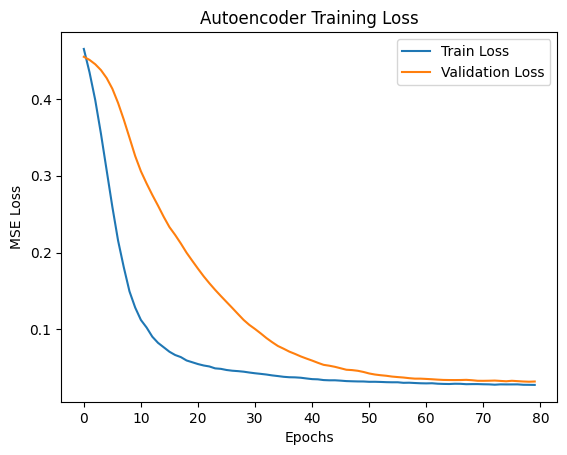

In [ ]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Autoencoder Training Loss")
plt.show()

### Autoencoder Testing

#### Threshold Optimisation: F1-optimized

In [ ]:
# Reconstruction error on val set
X_val_pred = autoencoder.predict(X_val_scaled)
mse_val = np.mean(np.power(X_val_scaled - X_val_pred, 2), axis=1)

# Search thresholds
thresholds = np.linspace(mse_val.min(), mse_val.max(), 100)
best_threshold_f1 = None
best_f1 = -1
results = []

for t in thresholds:
    y_pred = (mse_val > t).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_val_scaled, y_pred, average="binary", zero_division=0
    )

    results.append((t, precision, recall, f1))

    if f1 > best_f1:
        best_f1 = f1
        best_threshold_f1 = t

print(f"Best Threshold: {best_threshold_f1:.6f} with F1: {best_f1:.4f}")

4035/4035 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Best Threshold: 0.000011 with F1: 0.9993


#### Threshold Optimisation: Youden's J Statistic

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val_scaled, mse_val)
j_scores = tpr - fpr
best_threshold_j = thresholds[np.argmax(j_scores)]
print("Youden’s J best threshold:", best_threshold_j)

Youden’s J best threshold: 0.013520813175866071


#### F1 vs Threshold

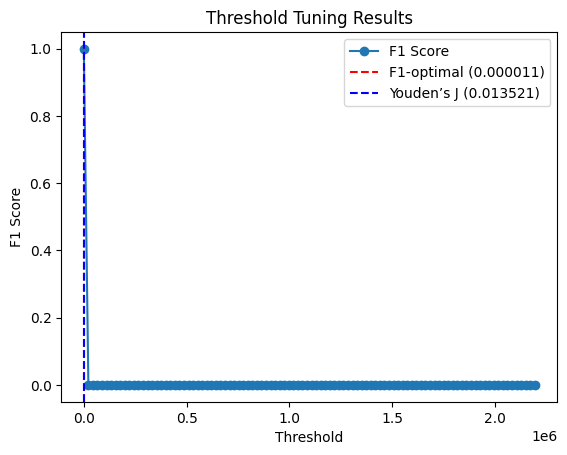

In [ ]:
# Extract thresholds and F1s from results (if you stored them)
thresholds = [r[0] for r in results]   # assumed format: (threshold, precision, recall, f1)
f1_scores = [r[3] for r in results]

plt.plot(thresholds, f1_scores, marker="o", label="F1 Score")

# Mark the two thresholds
plt.axvline(best_threshold_f1, color="red", linestyle="--", label=f"F1-optimal ({best_threshold_f1:.6f})")
plt.axvline(best_threshold_j, color="blue", linestyle="--", label=f"Youden’s J ({best_threshold_j:.6f})")

plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold Tuning Results")
plt.legend()
plt.show()


#### Model Evaluation

In [ ]:
# Get evaluations based on thresholds
for name, t in [("F1-optimized", best_threshold_f1), ("Youden’s J", best_threshold_j)]:
    y_pred_final = (mse_val > t).astype(int)
    print(f"\n{name} Threshold Results (t={t:.6f}):")
    print(classification_report(y_val_scaled, y_pred_final, digits=4, zero_division=0))


F1-optimized Threshold Results (t=0.000011):
              precision    recall  f1-score   support

         0.0     1.0000    0.0052    0.0103       193
         1.0     0.9985    1.0000    0.9993    128900

    accuracy                         0.9985    129093
   macro avg     0.9993    0.5026    0.5048    129093
weighted avg     0.9985    0.9985    0.9978    129093


Youden’s J Threshold Results (t=0.013521):
              precision    recall  f1-score   support

         0.0     0.0057    0.7098    0.0113       193
         1.0     0.9995    0.8144    0.8975    128900

    accuracy                         0.8143    129093
   macro avg     0.5026    0.7621    0.4544    129093
weighted avg     0.9980    0.8143    0.8962    129093



### Reconstruction error distributions

In [ ]:
plt.hist(mse[y_test_scaled == 0], bins=50, alpha=0.6, label="Benign")
plt.hist(mse[y_test_scaled == 1], bins=50, alpha=0.6, label="Malicious")
plt.axvline(best_threshold_j, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.show()

NameError: name 'mse' is not defined